In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -U accelerate
!pip install -U deepspeed  # for example
!pip install -U datasets
!pip install -U huggingface_hub
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# prompt: hugging face login
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn as nn


## Gemma

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM

def compute_shannon_entropy(values, bins=100):
    """
    Given a 1D NumPy array of values, compute the Shannon entropy in bits
    using a histogram-based approach.
    """
    # Build a histogram (density=True gives a probability density)
    hist, bin_edges = np.histogram(values, bins=bins, density=True)

    # Convert the density histogram to a probability mass function (pmf)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    pmf = hist * bin_widths  # approximate probability mass in each bin

    # Numerical stability: avoid taking log of zero
    pmf = pmf + 1e-30

    # Shannon entropy in bits
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def compute_model_and_layer_entropy(model_name_or_path, bins=100):
    """
    Loads a Hugging Face model, computes:
        1) The overall entropy for all parameters
        2) The entropy for each layer (by parameter name)

    Returns:
        overall_entropy (float) : Entropy in bits for the entire model.
        layer_entropies (dict)  : Mapping from layer/param name to entropy.
    """
    # 1. Load the model
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.eval()

    # 2. Prepare data structures
    all_params = []  # to hold all parameters for overall entropy
    layer_params = {}  # dict for layer-wise parameters

    # 3. Collect parameters
    for name, param in model.named_parameters():
        # Flatten and move to CPU -> NumPy
        param_values = param.data.view(-1).cpu().numpy()

        # Add to global list
        all_params.append(param_values)

        # Track layer/param name in a dict
        # You could store them by splitting the name if you want sub-layer grouping,
        # but here we just use the raw param name as the key.
        layer_params[name] = param_values

    # Concatenate all parameters into a single array for overall entropy
    all_params = np.concatenate(all_params, axis=0)

    # 4. Compute overall entropy
    overall_entropy = compute_shannon_entropy(all_params, bins=bins)

    # 5. Compute layer-wise entropy
    layer_entropies = {}
    for name, values in layer_params.items():
        layer_entropies[name] = compute_shannon_entropy(values, bins=bins)

    return overall_entropy, layer_entropies

if __name__ == "__main__":
    model_name = "google/gemma-3-1b-pt"  # Example model
    #model_name = "MottaCC/stories-gemma-3-1B"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy, layer_entropies = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )

    # Print results
    # print(f"Overall entropy (bits): {overall_entropy:.4f}\n")
    # print("Layer-by-layer entropy (bits):")
    # for layer_name, entropy_value in layer_entropies.items():
    #     print(f"  {layer_name}: {entropy_value:.4f}")

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM

def compute_shannon_entropy(values, bins=100):
    """
    Given a 1D NumPy array of values, compute the Shannon entropy in bits
    using a histogram-based approach.
    """
    # Build a histogram (density=True gives a probability density)
    hist, bin_edges = np.histogram(values, bins=bins, density=True)

    # Convert the density histogram to a probability mass function (pmf)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    pmf = hist * bin_widths  # approximate probability mass in each bin

    # Numerical stability: avoid taking log of zero
    pmf = pmf + 1e-30

    # Shannon entropy in bits
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def compute_model_and_layer_entropy(model_name_or_path, bins=100):
    """
    Loads a Hugging Face model, computes:
        1) The overall entropy for all parameters
        2) The entropy for each layer (by parameter name)

    Returns:
        overall_entropy (float) : Entropy in bits for the entire model.
        layer_entropies (dict)  : Mapping from layer/param name to entropy.
    """
    # 1. Load the model
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.eval()

    # 2. Prepare data structures
    all_params = []  # to hold all parameters for overall entropy
    layer_params = {}  # dict for layer-wise parameters

    # 3. Collect parameters
    for name, param in model.named_parameters():
        # Flatten and move to CPU -> NumPy
        param_values = param.data.view(-1).cpu().numpy()

        # Add to global list
        all_params.append(param_values)

        # Track layer/param name in a dict
        # You could store them by splitting the name if you want sub-layer grouping,
        # but here we just use the raw param name as the key.
        layer_params[name] = param_values

    # Concatenate all parameters into a single array for overall entropy
    all_params = np.concatenate(all_params, axis=0)

    # 4. Compute overall entropy
    overall_entropy = compute_shannon_entropy(all_params, bins=bins)

    # 5. Compute layer-wise entropy
    layer_entropies = {}
    for name, values in layer_params.items():
        layer_entropies[name] = compute_shannon_entropy(values, bins=bins)

    return overall_entropy, layer_entropies

if __name__ == "__main__":
    model_name = "MottaCC/psych-gemma-3-1B-v2"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy_psy, layer_entropies_psy = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )

    # Print results
    # print(f"Overall entropy (bits): {overall_entropy_psy:.4f}\n")
    # print("Layer-by-layer entropy (bits):")
    # for layer_name, entropy_value in layer_entropies_psy.items():
    #     print(f"  {layer_name}: {entropy_value:.4f}")

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM

def compute_shannon_entropy(values, bins=100):
    """
    Given a 1D NumPy array of values, compute the Shannon entropy in bits
    using a histogram-based approach.
    """
    # Build a histogram (density=True gives a probability density)
    hist, bin_edges = np.histogram(values, bins=bins, density=True)

    # Convert the density histogram to a probability mass function (pmf)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    pmf = hist * bin_widths  # approximate probability mass in each bin

    # Numerical stability: avoid taking log of zero
    pmf = pmf + 1e-30

    # Shannon entropy in bits
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def compute_model_and_layer_entropy(model_name_or_path, bins=100):
    """
    Loads a Hugging Face model, computes:
        1) The overall entropy for all parameters
        2) The entropy for each layer (by parameter name)

    Returns:
        overall_entropy (float) : Entropy in bits for the entire model.
        layer_entropies (dict)  : Mapping from layer/param name to entropy.
    """
    # 1. Load the model
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.eval()

    # 2. Prepare data structures
    all_params = []  # to hold all parameters for overall entropy
    layer_params = {}  # dict for layer-wise parameters

    # 3. Collect parameters
    for name, param in model.named_parameters():
        # Flatten and move to CPU -> NumPy
        param_values = param.data.view(-1).cpu().numpy()

        # Add to global list
        all_params.append(param_values)

        # Track layer/param name in a dict
        # You could store them by splitting the name if you want sub-layer grouping,
        # but here we just use the raw param name as the key.
        layer_params[name] = param_values

    # Concatenate all parameters into a single array for overall entropy
    all_params = np.concatenate(all_params, axis=0)

    # 4. Compute overall entropy
    overall_entropy = compute_shannon_entropy(all_params, bins=bins)

    # 5. Compute layer-wise entropy
    layer_entropies = {}
    for name, values in layer_params.items():
        layer_entropies[name] = compute_shannon_entropy(values, bins=bins)

    return overall_entropy, layer_entropies

if __name__ == "__main__":
    model_name = "MottaCC/stories-gemma-3-1B"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy_stories, layer_entropies_stories = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )

    # Print results
    #print(f"Overall entropy (bits): {overall_entropy_psy:.4f}\n")
    #print("Layer-by-layer entropy (bits):")
    # for layer_name, entropy_value in layer_entropies_psy.items():
    #     print(f"  {layer_name}: {entropy_value:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

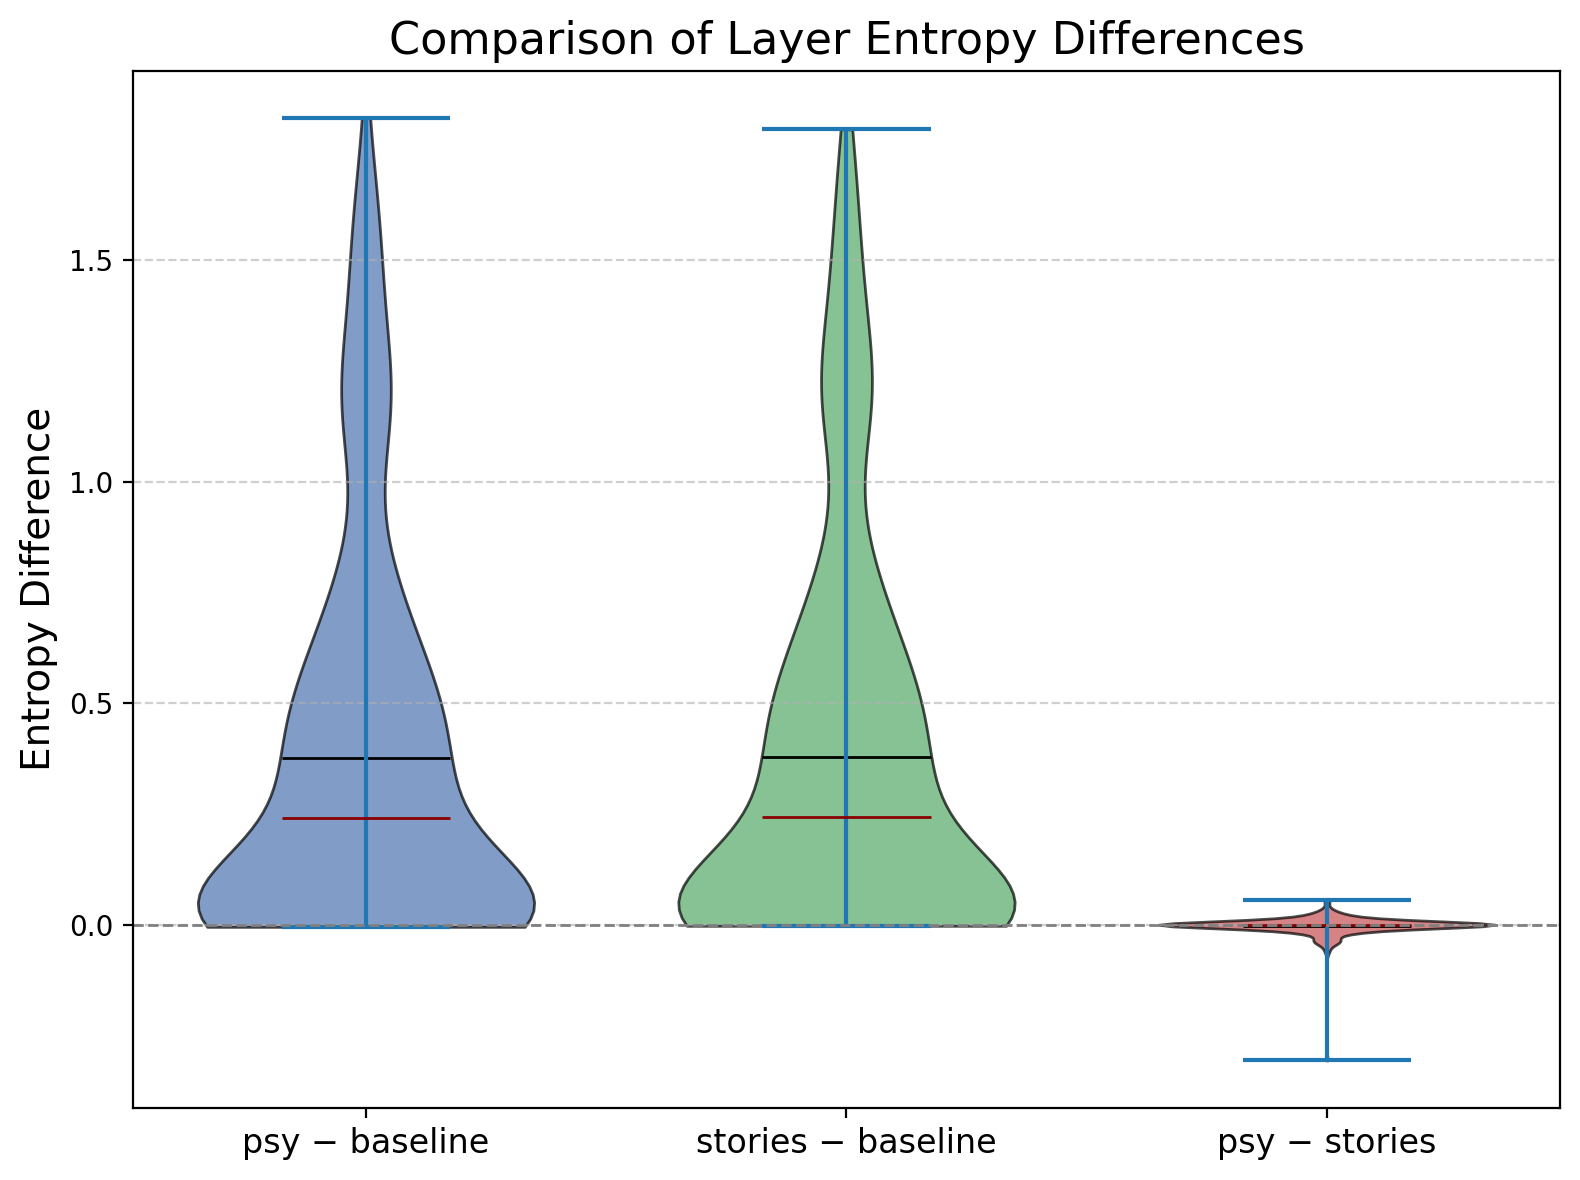

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# your three delta‐entropy arrays
d1 = np.array(list(layer_entropies_psy.values()))   - np.array(list(layer_entropies.values()))
d2 = np.array(list(layer_entropies_stories.values())) - np.array(list(layer_entropies.values()))
d3 = np.array(list(layer_entropies_psy.values()))   - np.array(list(layer_entropies_stories.values()))

data = [d1, d2, d3]
labels = ['psy − baseline', 'stories − baseline', 'psy − stories']
colors = ['#4C72B0', '#55A868', '#C44E52']

fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

# create violins at positions 1,2,3
parts = ax.violinplot(data,
                      positions=[1, 2, 3],
                      showmeans=True,
                      showmedians=True,
                      widths=0.7,
                      bw_method=0.3)

# color each body
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('black')
    body.set_alpha(0.7)

# style the means and medians
parts['cmeans'].set_color('black')
parts['cmeans'].set_linewidth(1)
parts['cmedians'].set_color('darkred')
parts['cmedians'].set_linewidth(1)

# set x‐ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels, fontsize=12)

# axes labels & title
ax.set_ylabel('Entropy Difference', fontsize=14)
ax.set_title('Comparison of Layer Entropy Differences', fontsize=16)

# optional y‐limits
#ax.set_ylim(-0.2, 0.2)

# add a horizontal zero‐line for reference
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# grid only on y‐axis
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

=== Overall Entropy Difference (psy - standard) ===
Overall difference: 0.0001

=== Statistics for Layer-Wise Differences (psy - standard) ===
  Mean: 0.3754
  Std:  0.4443
  Min:  -0.0050
  Max:  1.8220



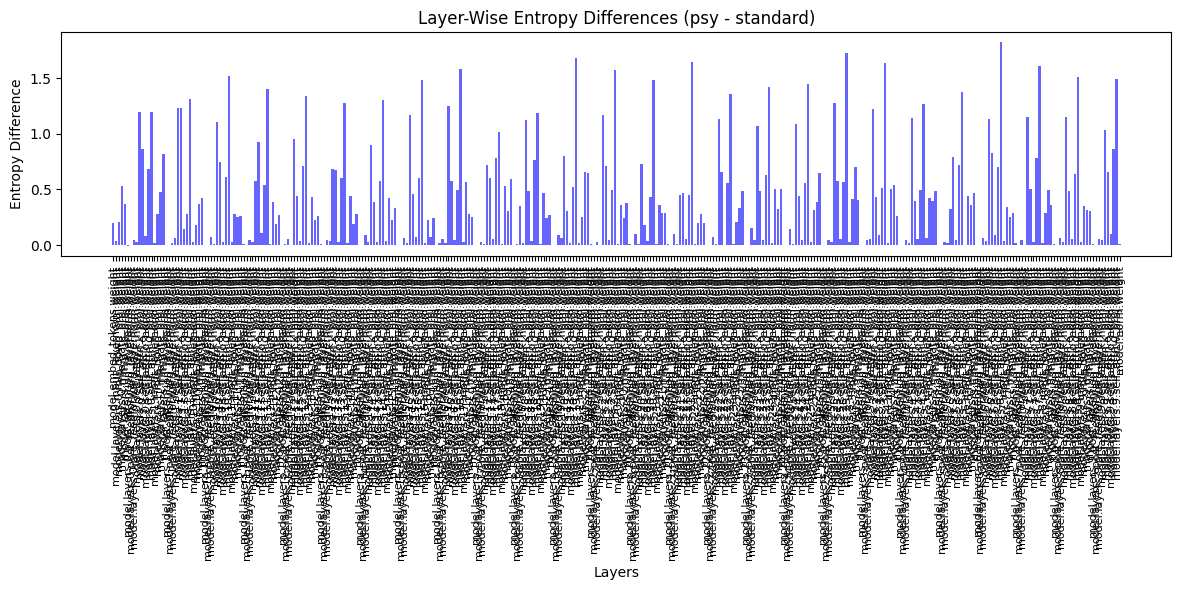

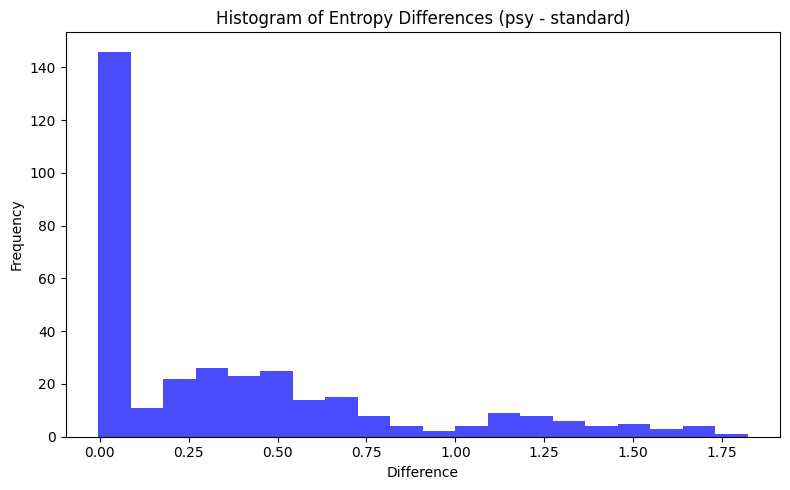

{'overall_diff': np.float64(0.00011049619653547005), 'layer_diff': {'model.embed_tokens.weight': np.float64(0.19743865098485003), 'model.layers.0.self_attn.q_proj.weight': np.float64(0.6845317621316092), 'model.layers.0.self_attn.k_proj.weight': np.float64(1.1975139076467372), 'model.layers.0.self_attn.v_proj.weight': np.float64(1.1924453616477848), 'model.layers.0.self_attn.o_proj.weight': np.float64(0.8672715360450738), 'model.layers.0.self_attn.q_norm.weight': np.float64(0.081073779305326), 'model.layers.0.self_attn.k_norm.weight': np.float64(0.03125), 'model.layers.0.mlp.gate_proj.weight': np.float64(0.5314704836043429), 'model.layers.0.mlp.up_proj.weight': np.float64(0.3734377205236079), 'model.layers.0.mlp.down_proj.weight': np.float64(0.2096108086024948), 'model.layers.0.input_layernorm.weight': np.float64(0.03849566412721561), 'model.layers.0.post_attention_layernorm.weight': np.float64(-0.00503257198502105), 'model.layers.0.pre_feedforward_layernorm.weight': np.float64(0.04243

In [ ]:
import numpy as np
import statistics
import matplotlib.pyplot as plt

def analyze_entropy_differences_psy_as_tuned(
    overall_entropy_standard,  # base model
    overall_entropy_psy,       # tuned model
    layer_entropies_standard,
    layer_entropies_psy
):
    """
    Computes differences in overall and layer-wise entropy where 'psy' is the tuned model
    and 'standard' is the base model. Generates basic stats and visualizations.

    Differences are computed as: (psy - standard).
    """

    # 1. Compute overall difference
    diff_overall = overall_entropy_psy - overall_entropy_standard
    print("=== Overall Entropy Difference (psy - standard) ===")
    print(f"Overall difference: {diff_overall:.4f}\n")

    # 2. Compute layer-wise differences (psy - standard)
    #    We'll assume both dicts have the same set of layer keys.
    layer_diff = {
        layer: layer_entropies_psy[layer] - layer_entropies_standard[layer]
        for layer in layer_entropies_standard
    }

    # 3. Basic statistics on layer-wise differences
    # Convert dict values to a list for easier stats
    diffs = list(layer_diff.values())

    mean_diff = statistics.mean(diffs)
    stdev_diff = statistics.pstdev(diffs)  # population stdev
    min_diff = min(diffs)
    max_diff = max(diffs)

    print("=== Statistics for Layer-Wise Differences (psy - standard) ===")
    print(f"  Mean: {mean_diff:.4f}")
    print(f"  Std:  {stdev_diff:.4f}")
    print(f"  Min:  {min_diff:.4f}")
    print(f"  Max:  {max_diff:.4f}\n")

    # 4. Visualization
    # We'll create:
    #   - a bar plot of layer-wise differences
    #   - a histogram of the differences

    # Sort layers for consistent ordering in the bar plot
    layers_sorted = sorted(layer_diff.keys())
    diffs_sorted = [layer_diff[layer] for layer in layers_sorted]

    # --- Bar Plot for Layer-Wise Differences ---
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(diffs_sorted)), diffs_sorted, color='blue', alpha=0.6)
    plt.xticks(range(len(diffs_sorted)), layers_sorted, rotation='vertical', fontsize=8)
    plt.title("Layer-Wise Entropy Differences (psy - standard)")
    plt.xlabel("Layers")
    plt.ylabel("Entropy Difference")
    plt.tight_layout()
    plt.show()

    # --- Histogram of Differences ---
    plt.figure(figsize=(8, 5))
    plt.hist(diffs, bins=20, color='blue', alpha=0.7)
    plt.title("Histogram of Entropy Differences (psy - standard)")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Return results if needed
    return {
        "overall_diff": diff_overall,
        "layer_diff": layer_diff,
        "stats": {
            "mean": mean_diff,
            "stdev": stdev_diff,
            "min": min_diff,
            "max": max_diff
        }
    }

if __name__ == "__main__":

    results = analyze_entropy_differences_psy_as_tuned(
        overall_entropy,
        overall_entropy_psy,
        layer_entropies,
        layer_entropies_psy
    )

    # The function prints info and returns a dict with differences & stats
    print(results)

In [ ]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM

def compute_shannon_entropy(values: np.ndarray, bins: int = 100) -> float:
    """
    Given a 1D NumPy array of values, compute the Shannon entropy in bits
    using a histogram-based approach.
    """
    hist, bin_edges = np.histogram(values, bins=bins, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    pmf = hist * bin_widths
    pmf = pmf + 1e-30                   # avoid log(0)
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def compute_weight_diff_entropies(
    model_a_name_or_path: str,
    model_b_name_or_path: str,
    bins: int = 100,
    device: str = "cpu"
):
    """
    Load two models, compute the difference in each shared parameter,
    and compute Shannon entropy (in bits) of those differences:
      • overall_entropy: entropy of all deltas concatenated
      • layer_entropies: dict mapping parameter name → entropy of its delta
    """
    # 1. Load both models
    model_a = AutoModelForCausalLM.from_pretrained(model_a_name_or_path).to(device)
    model_b = AutoModelForCausalLM.from_pretrained(model_b_name_or_path).to(device)
    model_a.eval()
    model_b.eval()

    # 2. Compute per-parameter deltas
    all_deltas = []
    layer_entropies = {}

    for (name_a, param_a), (name_b, param_b) in zip(
        model_a.named_parameters(), model_b.named_parameters()
    ):
        if name_a != name_b:
            raise ValueError(f"Parameter mismatch: {name_a} vs {name_b}")

        delta = (param_b.detach() - param_a.detach()).view(-1).cpu().numpy()
        all_deltas.append(delta)

        # per-layer entropy
        layer_entropies[name_a] = compute_shannon_entropy(delta, bins=bins)

    # 3. Overall entropy
    all_deltas_concat = np.concatenate(all_deltas, axis=0)
    overall_entropy = compute_shannon_entropy(all_deltas_concat, bins=bins)

    return overall_entropy, layer_entropies

# ─── USER PARAMETERS ───────────────────────────────────────────────────────────
# base_model      = "MottaCC/stories-gemma-3-1B"             # e.g. "gpt2" or path/to/base
# finetuned_model = "MottaCC/psych-gemma-3-1B-v2"
base_model      = "MottaCC/stories-gemma-3-1B"             # e.g. "gpt2" or path/to/base
finetuned_model = "MottaCC/psych-gemma-3-1B-v2"
bins            = 10000
device          = "cuda"             # or "cpu"
# ────────────────────────────────────────────────────────────────────────────────

# Compute entropies
overall_ent, layer_ents = compute_weight_diff_entropies(
    model_a_name_or_path=base_model,
    model_b_name_or_path=finetuned_model,
    bins=bins,
    device=device
)

# Display results
print(f"\nOverall entropy of weight differences: {overall_ent:.6f} bits\n")
print("Layer-by-layer entropy of weight differences:")
for name, ent in layer_ents.items():
    print(f"  {name:<60} {ent:.6f}")


Overall entropy of weight differences: 10.755989 bits

Layer-by-layer entropy of weight differences:
  model.embed_tokens.weight                                    9.429438
  model.layers.0.self_attn.q_proj.weight                       12.261492
  model.layers.0.self_attn.k_proj.weight                       12.243438
  model.layers.0.self_attn.v_proj.weight                       12.315291
  model.layers.0.self_attn.o_proj.weight                       12.197455
  model.layers.0.self_attn.q_norm.weight                       7.968750
  model.layers.0.self_attn.k_norm.weight                       7.960938
  model.layers.0.mlp.gate_proj.weight                          12.039437
  model.layers.0.mlp.up_proj.weight                            12.040841
  model.layers.0.mlp.down_proj.weight                          12.084013
  model.layers.0.input_layernorm.weight                        8.941133
  model.layers.0.post_attention_layernorm.weight               9.977838
  model.layers.0.pre_feedfo

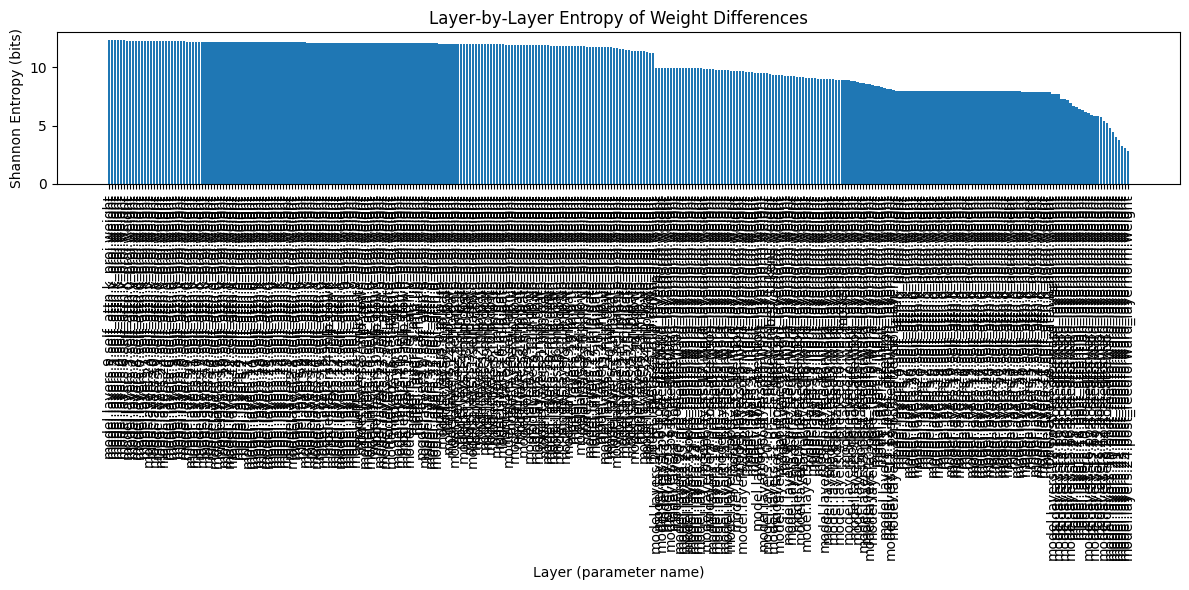

In [ ]:
import matplotlib.pyplot as plt

# Sort layers by descending entropy
layers, ents = zip(
    *sorted(layer_ents.items(), key=lambda x: x[1], reverse=True)
)

# Create a bar‐chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(layers)), ents)
plt.xticks(range(len(layers)), layers, rotation=90)
plt.xlabel("Layer (parameter name)")
plt.ylabel("Shannon Entropy (bits)")
plt.title("Layer‐by‐Layer Entropy of Weight Differences")
plt.tight_layout()
plt.show()

## Llama

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM

def compute_shannon_entropy(values, bins=100):
    """
    Given a 1D NumPy array of values, compute the Shannon entropy in bits
    using a histogram-based approach.
    """
    # Build a histogram (density=True gives a probability density)
    hist, bin_edges = np.histogram(values, bins=bins, density=True)

    # Convert the density histogram to a probability mass function (pmf)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    pmf = hist * bin_widths  # approximate probability mass in each bin

    # Numerical stability: avoid taking log of zero
    pmf = pmf + 1e-30

    # Shannon entropy in bits
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def compute_model_and_layer_entropy(model_name_or_path, bins=100):
    """
    Loads a Hugging Face model, computes:
        1) The overall entropy for all parameters
        2) The entropy for each layer (by parameter name)

    Returns:
        overall_entropy (float) : Entropy in bits for the entire model.
        layer_entropies (dict)  : Mapping from layer/param name to entropy.
    """
    # 1. Load the model
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.eval()

    # 2. Prepare data structures
    all_params = []  # to hold all parameters for overall entropy
    layer_params = {}  # dict for layer-wise parameters

    # 3. Collect parameters
    for name, param in model.named_parameters():
        # Flatten and move to CPU -> NumPy
        param_values = param.data.view(-1).cpu().numpy()

        # Add to global list
        all_params.append(param_values)

        # Track layer/param name in a dict
        # You could store them by splitting the name if you want sub-layer grouping,
        # but here we just use the raw param name as the key.
        layer_params[name] = param_values

    # Concatenate all parameters into a single array for overall entropy
    all_params = np.concatenate(all_params, axis=0)

    # 4. Compute overall entropy
    overall_entropy = compute_shannon_entropy(all_params, bins=bins)

    # 5. Compute layer-wise entropy
    layer_entropies = {}
    for name, values in layer_params.items():
        layer_entropies[name] = compute_shannon_entropy(values, bins=bins)

    return overall_entropy, layer_entropies

if __name__ == "__main__":
    model_name = "meta-llama/Llama-3.2-1B"  # Example model
    #model_name = "MottaCC/stories-gemma-3-1B"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy, layer_entropies = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )

    model_name = "MottaCC/stories-llama-3-1B"  # Example model
    #model_name = "MottaCC/stories-gemma-3-1B"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy_stories, layer_entropies_stories = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )

    model_name = "MottaCC/psych-llama-3-1B-v1"  # Example model
    #model_name = "MottaCC/stories-gemma-3-1B"  # Example model
    bins = 10000

    # Compute entropies
    overall_entropy, layer_entropies_psy = compute_model_and_layer_entropy(
        model_name_or_path=model_name,
        bins=bins
    )
    # Print results
    # print(f"Overall entropy (bits): {overall_entropy:.4f}\n")
    # print("Layer-by-layer entropy (bits):")
    # for layer_name, entropy_value in layer_entropies.items():
    #     print(f"  {layer_name}: {entropy_value:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

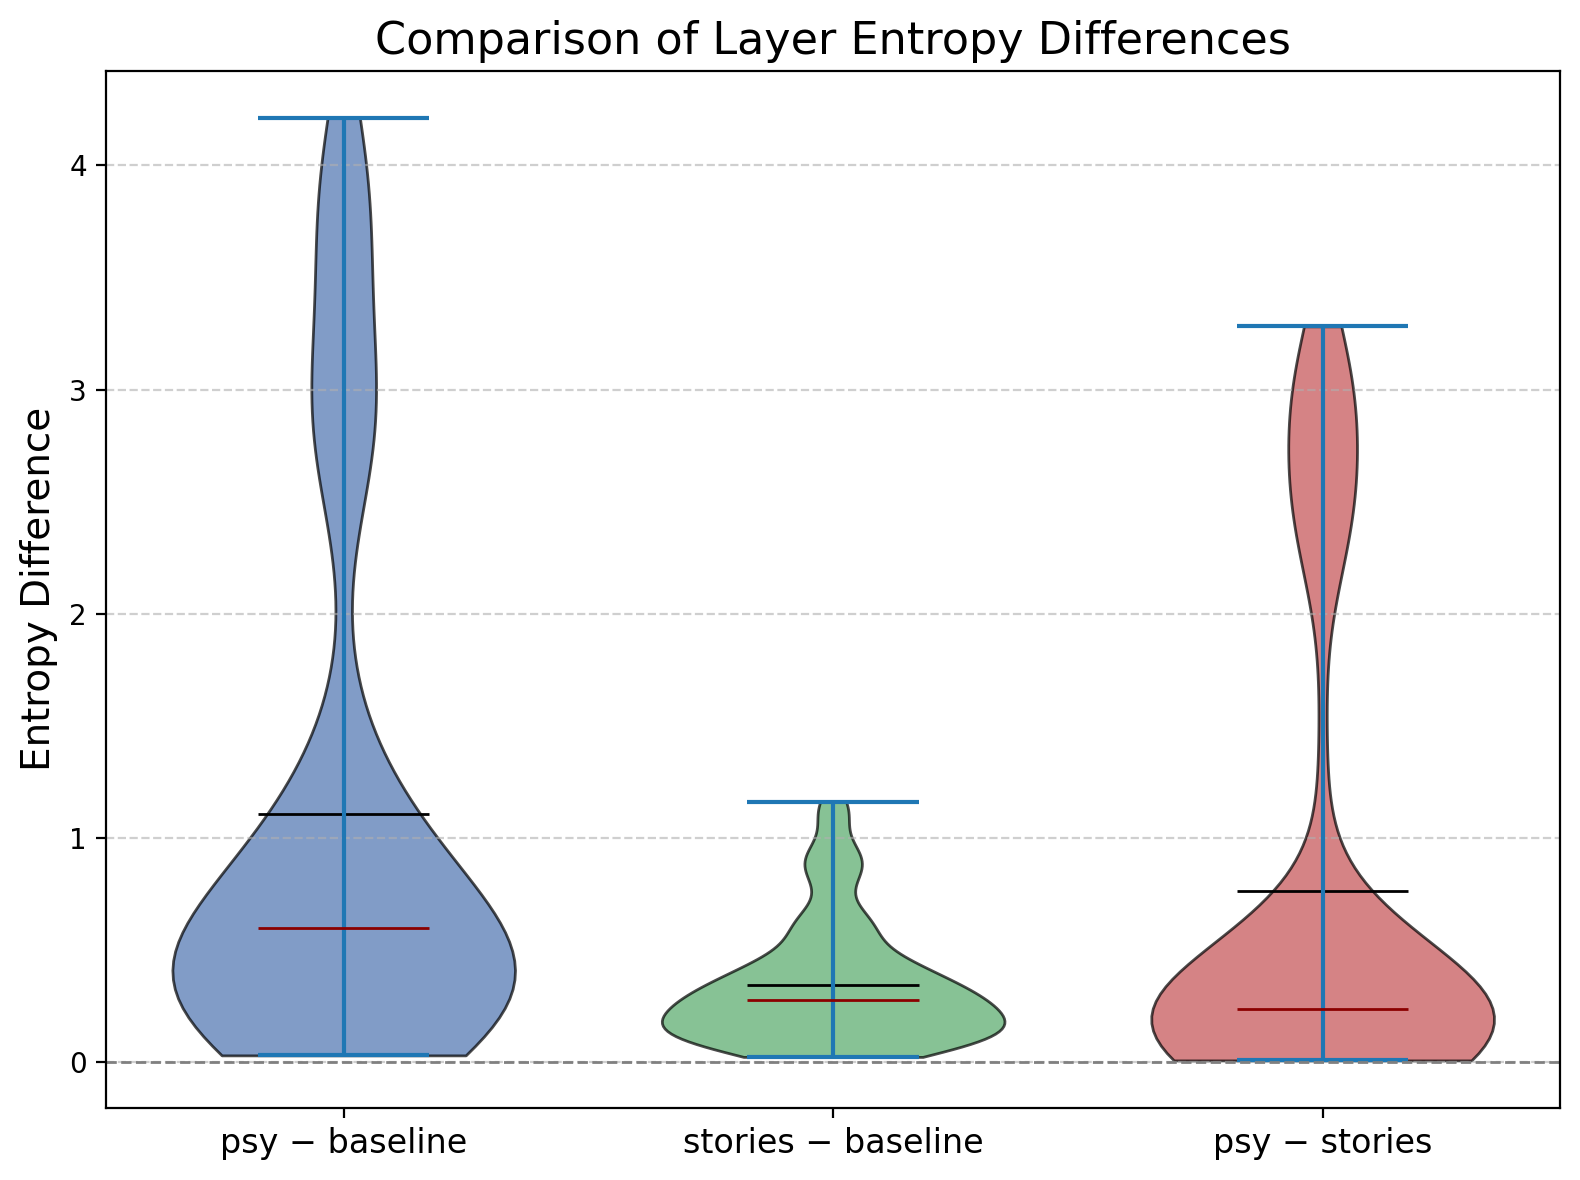

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# your three delta‐entropy arrays
d1 = np.array(list(layer_entropies_psy.values()))   - np.array(list(layer_entropies.values()))
d2 = np.array(list(layer_entropies_stories.values())) - np.array(list(layer_entropies.values()))
d3 = np.array(list(layer_entropies_psy.values()))   - np.array(list(layer_entropies_stories.values()))

data = [d1, d2, d3]
labels = ['psy − baseline', 'stories − baseline', 'psy − stories']
colors = ['#4C72B0', '#55A868', '#C44E52']

fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

# create violins at positions 1,2,3
parts = ax.violinplot(data,
                      positions=[1, 2, 3],
                      showmeans=True,
                      showmedians=True,
                      widths=0.7,
                      bw_method=0.3)

# color each body
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('black')
    body.set_alpha(0.7)

# style the means and medians
parts['cmeans'].set_color('black')
parts['cmeans'].set_linewidth(1)
parts['cmedians'].set_color('darkred')
parts['cmedians'].set_linewidth(1)

# set x‐ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels, fontsize=12)

# axes labels & title
ax.set_ylabel('Entropy Difference', fontsize=14)
ax.set_title('Comparison of Layer Entropy Differences', fontsize=16)

# optional y‐limits
#ax.set_ylim(-0.2, 0.2)

# add a horizontal zero‐line for reference
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# grid only on y‐axis
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()